In [ ]:
import pandas as pd
import numpy as np
import torch, os, cv2, torchvision
import albumentations as A
from torchvision import transforms as T
from PIL import Image
from glob import glob
import gdown
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
def get_data(path, fl_name = "pollen"):
    if os.path.isdir(path): print("Data has already downloaded") ;pass
    else:
        os.makedirs(path, exist_ok=True)
        url = 'https://drive.google.com/file/d/1JZk7ngaip1j-UB0H2Wh0QYKWNEBr-mQ7/view?usp=sharing' if fl_name =="pollen" else None

        data_id = url.split("/")[-2]
        prefix = "https://drive.google.com/uc?/export=download&id="

        gdown.download(prefix+data_id, path, quiet = False)
        folder = glob(f"{path}/*")[0]
        os.system(f"unzip {folder} -d {path}")
        os.remove(folder)


get_data(path="Pollen")


Downloading...
From: https://drive.google.com/uc?/export=download&id=1JZk7ngaip1j-UB0H2Wh0QYKWNEBr-mQ7
To: /content/Pollen
100%|██████████| 25.2M/25.2M [00:00<00:00, 59.7MB/s]


In [41]:
class CustomDataset(Dataset):
    def __init__(self, root, transformations = None):
        super(). __init__()

        self.transformations =transformations
        self.im_paths = [im_path for im_path in sorted(glob(f"{root}/*.jpg"))]

        self.label = []
        self.class_name = {}
        for idx, im_path in  enumerate(self.im_paths):

            labellar = self.get_clas_name(im_path)
            self.label.append(labellar)
            self.uniq_class = [cls for cls in np.unique(list(self.label))]
            self.class_name = {keys: qiymat for qiymat, keys in enumerate(self.uniq_class)}

    def get_clas_name (self, path):
        return os.path.basename(path).split("_")[0] if "_" in os.path.basename(path) else os.path.basename(path).split(" ")[0]

    def __len__(self): return len(self.im_paths)


    def __getitem__(self, idx):

        im_path = self.im_paths[idx]
        im = Image.open(im_path)

        gt = self.class_name[self.get_clas_name(im_path)]

        if self.transformations is not None: im = self.transformations(im)



        return im, gt

transformer = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()])

data= CustomDataset(root= "Pollen", transformations =transformer)
class_names =data.class_name

In [42]:
split=[0.85, 0.05]
len_data = len(data)
tr_len = int(len_data * split[0])
val_len = int(len_data * split[1])
test_len = len_data-tr_len-val_len

tr_ds, val_ds, test_ds = random_split(dataset=data, lengths=[tr_len, val_len, test_len])
print(f"Train len ->  {tr_len}")
print(f"Val len   ->  {val_len}")
print(f"Test len  ->  {test_len}")

Train len ->  671
Val len   ->  39
Test len  ->  80


In [43]:

def get_dataLD(root, bs, nw, ):

    tr_dl = DataLoader(tr_ds, batch_size= bs, shuffle=True, num_workers=nw)
    val_dl = DataLoader(val_ds, batch_size= bs, shuffle=False, num_workers=nw)
    test_dl = DataLoader(test_ds, batch_size= bs, shuffle=False, num_workers=nw)

    return tr_dl, val_dl, test_dl

tr_dl, val_dl, test_dl = get_dataLD(root ="Pollen", bs = 16, nw = 0)

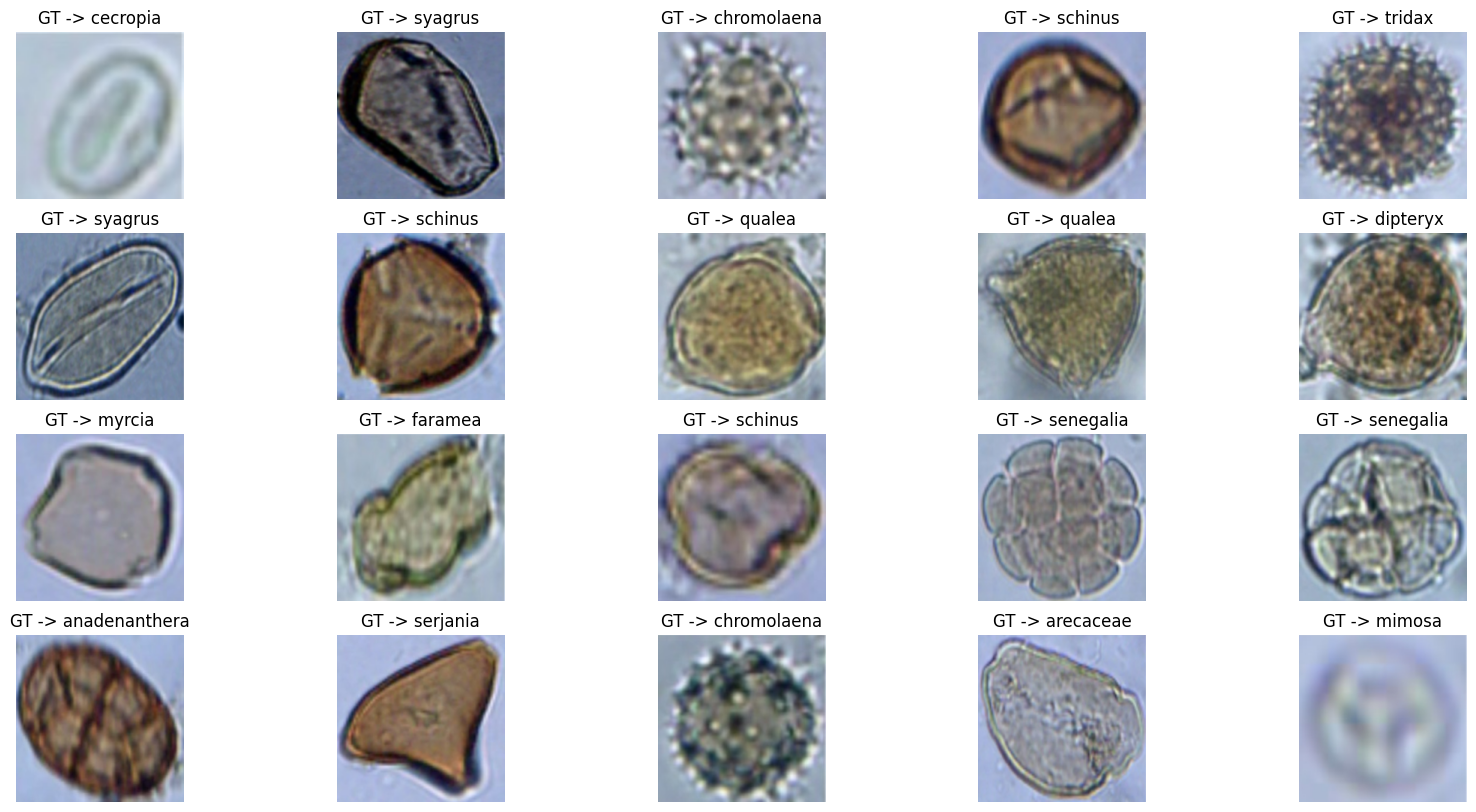

In [56]:
import random
from matplotlib import pyplot as plt

def visualize(data, n_ims, rows, cmap = None, cls_names = None):

    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):

        im, gt = data[indeks]

        plt.subplot(rows, n_ims // rows, idx + 1)

        plt.imshow((im*255).cpu().permute(2,1,0).numpy().astype("uint8"))

        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")

visualize(tr_dl.dataset, 20, 4, "rgb", list(data.class_name.keys()))

In [ ]:
! pip install timm

In [ ]:
import timm, torch

model = timm.create_model("resnet18", pretrained=True, num_classes = len(data.class_name))
model.eval()


In [ ]:
epochs= 10
device = "cuda" if torch.cuda.is_available() else 'cpu'

loss_fc = torch.nn.CrossEntropyLoss()
optimazer = torch.optim.Adam(params = model.parameters(), lr=0.0003)
model.to(device)


In [ ]:

def train(model, tr_dl, val_dl, epochs, opt, device, loss_fc, save_prefix):
    tr_acc_, tr_loss_ = [], []
    val_acc_, val_loss_ = [],[]

    best_loss, best_acc, threshold = 0, float("inf"), 0.01
    # os.makedirs("saved_models", exist_ok=True)

    for epoc in range(epochs):

        print(f" {epoc+1} - epoc is starting .........")
        tr_acc,tr_total, tr_loss = 0,0,0
        for idx, batch in enumerate(tr_dl):
            im, gt =batch
            im, gt = im.to(device), gt.to(device)

            pred = model(im)
            loss = loss_fc(pred, gt)

            tr_total+= im.shape[0]
            pred_class = torch.argmax(pred, dim=1)

            tr_acc+=(pred_class==gt).sum().item()
            tr_loss+=loss.item()




            opt.zero_grad()
            loss.backward()
            opt.step()

            # for print
        tr_acc_j =tr_acc/tr_total
        tr_loss_j = tr_loss/len(tr_dl)

        tr_acc_.append(tr_acc_j)
        tr_loss_.append(tr_loss_j)
        print(f"{epoc+1}-epoc  Train result.\n ")

        print(f"{epoc+1}- epoc Train Accuracy Score        -> {tr_acc_j:.2f}")
        print(f"{epoc+1}- epoc Train loss                   -> {tr_loss_j:.2f}\n")



        model.eval()

        with torch.no_grad():

            val_acc, val_loss, val_total =0,0,0


            for idx, batch in enumerate(val_dl):
                im, gt = batch
                im, gt = im.to(device), gt.to(device)

                pred =model(im)
                val_total+=im.shape[0]

                loss =loss_fc(pred, gt)
                pred_class = torch.argmax(pred, dim=1)

                val_acc+= (pred_class==gt).sum().item()

                val_loss+=loss.item()



                #  for print
            val_acc_j =val_acc/val_total
            val_loss_j = val_loss/len(val_dl)


            print(f"{epoc+1}-epoc Validation ")
            print(f"{epoc+1}- epoc Validation Accuracy Score   -> {val_acc_j:.2f}")
            print(f"{epoc+1}- epoc Validation loss             -> {val_loss_j:.2f}\n\n")

            val_acc_.append(val_acc_j)
            val_loss_.append(val_loss_j)


            if val_loss_j < (best_loss + threshold):

              os.makedirs("saved_models", exist_ok=True)
              # best_acc = val_acc
              best_loss = val_loss_j
              torch.save(model.state_dict(), f"saved_models/{save_prefix}_best_model.pth")
              print("model is saved")


    return {"tr_acc_cs": tr_acc_, "tr_loss": tr_loss_, "val_acc_cs": val_acc_, "val_loss": val_loss_}


In [10]:

def train(model, tr_dl, val_dl, epochs, device, loss_fc, opt, save_prefix):
  tr_acc_sc_ = []
  val_acc_sc_, val_epoc_loss_ = [],[]
  tr_total =0
  best_loss = np.inf
  decrease, not_improve, early_stop_threshold= 1,0,5

  print("Train is starting .....")

  for epoc in range(epochs):
      print(f"{epoc+1}- epoc is starting..")
      count=0
      tr_acc_sr, tr_total =0,0

      for idx, batch in enumerate(tr_dl):
          ims, gts = batch
          ims = ims.to(device)
          gts = gts.to(device)

          pred = model(ims)
          loss = loss_fc(pred, gts)

          tr_total+=ims.shape[0]
          pred_class = torch.argmax(pred, dim =1)
          count+=1
          tr_acc_sr+= (pred_class==gts).sum().item()

          optimazer.zero_grad()
          loss.backward()
          optimazer.step()

      model.eval()
      with torch.no_grad():
          val_acc_sc = 0
          val_total =0
          val_epoc_loss = 0

          for idx, batch in enumerate(val_dl):
              ims, gts = batch
              ims, gts = ims.to(device), gts.to(device)

              val_total+=ims.shape[0]

              pred = model(ims)


              pred_class = torch.argmax(pred, dim=1)
              val_acc_sc+=(pred_class==gts).sum().item()
              loss = loss_fc(pred, gts)
              val_epoc_loss+=loss.item()

              tr_ACC_SR = tr_acc_sr/tr_total
              VAL_acc_sc = val_acc_sc/val_total
              VAL_epoc_loss = val_epoc_loss/len(val_dl)


          print(f"{epoc+1} is finished..")
          print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
          print(f"{epoc+1} - epoc result:\n")
          print(f"{epoc+1}- epoc Train Accurancy score        -> {tr_ACC_SR:.3f}")
          print(f"{epoc+1}- epoc Validation Accurancy score   -> {VAL_acc_sc:.3f}")
          print(f"{epoc+1}- epoc Validation loss score        -> {VAL_epoc_loss:.3f}\n\n")


          tr_acc_sc_.append(tr_ACC_SR)
          val_acc_sc_.append(VAL_acc_sc)
          val_epoc_loss_.append(VAL_epoc_loss)


          print(type(best_loss))

          if VAL_epoc_loss < best_loss:
              os.makedirs("best_model", exist_ok=True)
              best_loss = VAL_epoc_loss
              torch.save(model, f"best_model/{save_prefix}_best_model.pth")




  return {"tr_acc_sc": tr_acc_sc_, "val_acc_sc": val_acc_sc_, "val_epoc_loss": val_epoc_loss_}



In [11]:
result = train(model=model, tr_dl=tr_dl, val_dl=val_dl, epochs=6, device=device,
               loss_fc=loss_fc, opt=optimazer, save_prefix="Pollen")

Train is starting .....
1- epoc is starting..
1 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1 - epoc result:

1- epoc Train Accurancy score        -> 0.224
1- epoc Validation Accurancy score   -> 0.538
1- epoc Validation loss score        -> 1.504


<class 'float'>
2- epoc is starting..
2 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2 - epoc result:

2- epoc Train Accurancy score        -> 0.526
2- epoc Validation Accurancy score   -> 0.718
2- epoc Validation loss score        -> 0.810


<class 'float'>
3- epoc is starting..
3 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3 - epoc result:

3- epoc Train Accurancy score        -> 0.803
3- epoc Validation Accurancy score   -> 0.795
3- epoc Validation loss score        -> 0.583


<class 'float'>
4- epoc is starting..
4 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4 - epoc result:

4- epoc Train Accurancy score        -> 0.905
4- epoc Validation Accurancy score   -> 0.923
4- epoc Validation loss score        -> 0.274


<class '

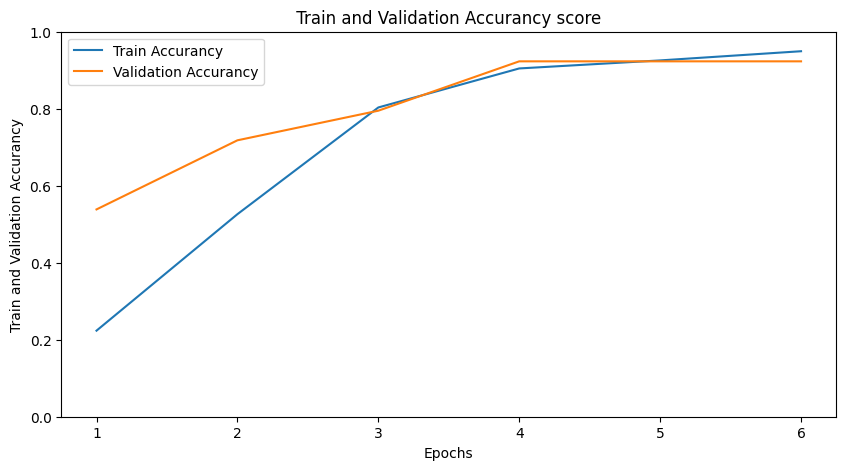

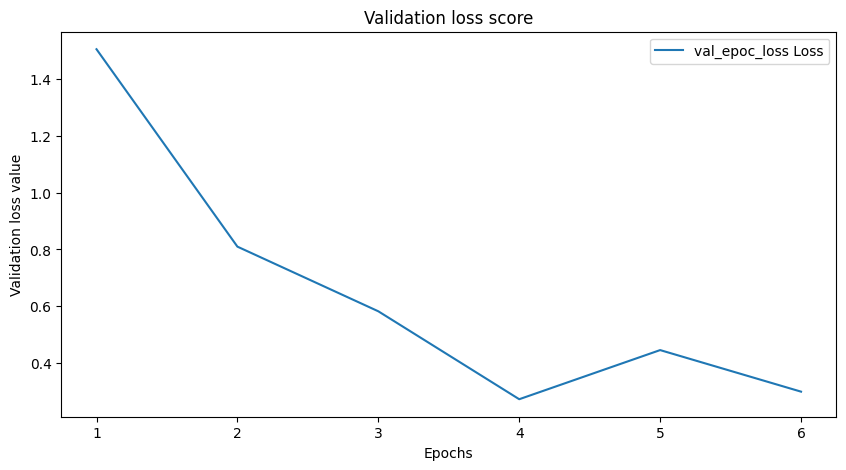

In [13]:
import matplotlib.pyplot as plt

class Plot():
    def __init__(self, res):


        plt.figure(figsize =(10,5))
        plt.plot(res['tr_acc_sc'], label = 'Train Accurancy')
        plt.plot(res['val_acc_sc'], label = 'Validation Accurancy')
        plt.title(" Train and Validation Accurancy score ")
        plt.xlabel('Epochs')
        plt.xticks(np.arange(len(res['val_acc_sc'])), [i for i in range(1, len(res['val_acc_sc']) + 1)])
        plt.ylabel('Train and Validation Accurancy')
        plt.ylim(0, 1)
        plt.legend()
        plt.show()

        plt.figure(figsize = (10, 5))
        plt.plot(res['val_epoc_loss'], label = "val_epoc_loss Loss")
        # plt.plot(res['val_loss'], label = "Validation Loss")
        plt.title("Validation loss score")
        plt.xlabel('Epochs')
        plt.xticks(np.arange(len(res['val_epoc_loss'])), [i for i in range(1, len(res['val_epoc_loss']) + 1)])

        plt.ylabel("Validation loss value")
        # plt.ylim(0, 1.5)
        plt.legend()
        plt.show()
Plot(result)






In [28]:
import random

In [ ]:
def inference(model, device, data, num_ims,  cls_names = None):

    preds, images = [], []
    for idx, (im, target) in enumerate(data):

        pred_class = torch.argmax(model(im.unsqueeze(dim = 0).to(device)), dim = 1)

        images.append(im)
        preds.append(pred_class)
        print(len(pred_class))
    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(images) - 1) for _ in range(num_ims)]

    for idx, indeks in enumerate(indekslar):

        im = images[indeks]

        # Start plot

        # plt.imshow(tensor_2_im(im), cmap = "gray"); plt.axis("off")
        plt.imshow((im*255).cpu().permute(2,1,0).numpy().astype("uint8"))

        plt.title(f"PRED -> {cls_names[preds[indeks]]}")


model = torch.load("best_model/Pollen_best_model.pth")
inference(model = model.to(device), device = device, data = test_ds.dataset, num_ims = 10,  cls_names = list(class_names))

In [ ]:
class_names

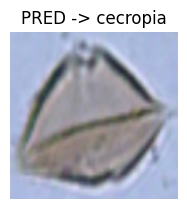

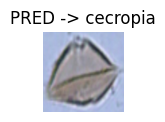

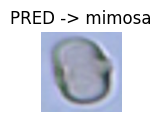

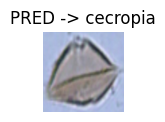

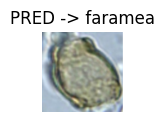

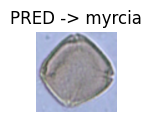

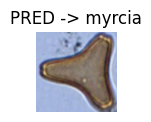

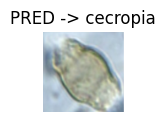

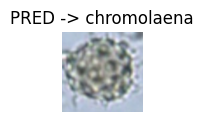

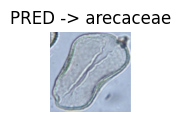

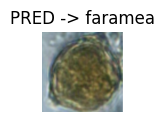

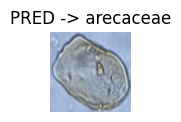

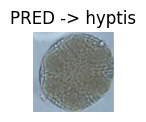

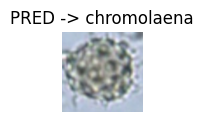

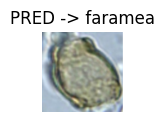

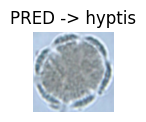

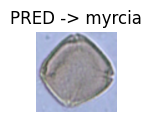

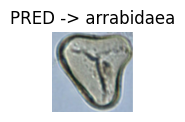

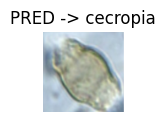

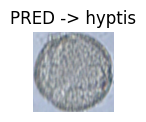

In [55]:

import random
def inference(data, model, device, rasmlar_soni, rows,  class_name=None):
    bashoratlar, rasmlar = [], []

    for idx, (rasm ,batch) in enumerate(data):
        if idx == rasmlar_soni: break
        rasmlar.append(rasm) # 3D
        bashorat = torch.argmax(model(rasm.unsqueeze(dim = 0).to(device)), dim = 1)
        bashoratlar.append(bashorat)

    plt.figure(figsize=(20, 10))
    indekslar = [random.randint(0, len(rasmlar)-1) for _ in range(rasmlar_soni)]

    for idx, indeks in enumerate(indekslar):
        rasm = rasmlar[indeks]

        plt.subplot(rows, rasmlar_soni // rows, idx + 1)
        plt.imshow((rasm*255).cpu().permute(2,1,0).numpy().astype("uint8"))
        plt.axis("off")
        plt.title(f"PRED -> {class_name[bashoratlar[indeks]]}")
        plt.show()

model = torch.load("best_model/Pollen_best_model.pth")
inference(data=test_dl.dataset, model=model.to(device), device=device, rasmlar_soni=20, rows=4, class_name=list(class_names.keys()))